## Importando dependências

In [1]:
# pip install tensorflow sklearn

In [2]:
import numpy as np
import sys
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.losses import Loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Binarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Importando dataset e splitando em teste e treino

In [3]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])
    dataset.iloc[:, -1] = y
    
def binarize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    binarizer = Binarizer()
    y = binarizer.fit_transform([y])[0]
    dataset.iloc[:, -1] = y
    

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset_02_24 = pd.read_csv('dataset-oi-2017-02-24.csv', names=HEADER)
initial_dataset_02_26 = pd.read_csv('dataset-oi-2017-02-26.csv', names=HEADER)

initial_dataset_02_24 = initial_dataset_02_24.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_26 = initial_dataset_02_26.replace([np.inf, -np.inf], np.nan).dropna()

initial_dataset = initial_dataset_02_24.append(initial_dataset_02_26, ignore_index=True)

binarize_dataset_labels(initial_dataset)

## Criando modelo do cliente

In [42]:
class Client:
    def __init__(self, client_id = 123, dataset = [1.0, 2.0]):
        self.client_id = client_id
        self.local_dataset = pd.DataFrame(dataset)
        self.local_tree = DecisionTreeClassifier(random_state=0, max_depth=20, criterion='entropy')
        self.metrics_history = list()
        self.local_forest = [self.local_tree]
        
    def apply_oversample(self, X, y):
        labels_counts = self.local_dataset['class'].value_counts()
        target_label = labels_counts.keys()[1]
        max_samples = int(labels_counts.values[0] * 0.6)
        current_samples = labels_counts.values[1]
        
        if current_samples >= max_samples:
            return X, y
        
        smote_oversample = SMOTE(sampling_strategy={target_label: max_samples}, random_state=0)
        return smote_oversample.fit_resample(X, y)

        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values
        
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        X, y = self.apply_oversample(X, y)
                
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
        
    def train_tree(self):
        # depth 35 é o melhor aplicando grid seach
        self.local_tree.fit(self.X_train, self.y_train)
        
    def test_tree(self):
        y_pred = self.local_tree.predict(self.X_test)
        
        precision = Precision()
        precision.update_state(self.y_test, y_pred)
        self.local_tree_prec = precision.result().numpy()
        
        self.local_tree_acc = self.local_tree.score(self.X_test, self.y_test)
        print(f"[INFO] Accuracy of client {self.client_id} tree = {self.local_tree_acc}")
        
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm)  

## Splitando dataset para os clientes da rede

In [43]:
num_clients = 20
max_num_trees = 10
clients = [Client(client_id = i) for i in range(num_clients)]

# pega os N primeiros clientes com mais dados e que possuem dataset com > 1 classe
unique_ips = initial_dataset['srcip'].value_counts().head(num_clients + 10).keys()
client_index, srcip = (0,0)
while client_index < num_clients:
    local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[srcip]]
    num_classes = len(local_dataset['class'].value_counts())
    if num_classes > 1:
        print(f"values counts for client {client_index} = {local_dataset['class'].value_counts()}")
        clients[client_index].local_dataset = local_dataset
        client_index += 1
    srcip += 1
        

values counts for client 0 = 0.0    287944
1.0     37973
Name: class, dtype: int64
values counts for client 1 = 0.0    221592
1.0     90218
Name: class, dtype: int64
values counts for client 2 = 0.0    201866
1.0        58
Name: class, dtype: int64
values counts for client 3 = 1.0    90924
0.0    65471
Name: class, dtype: int64
values counts for client 4 = 0.0    88587
1.0     6795
Name: class, dtype: int64
values counts for client 5 = 0.0    69581
1.0     8601
Name: class, dtype: int64
values counts for client 6 = 1.0    36894
0.0    36007
Name: class, dtype: int64
values counts for client 7 = 0.0    45865
1.0    24756
Name: class, dtype: int64
values counts for client 8 = 0.0    64374
1.0       15
Name: class, dtype: int64
values counts for client 9 = 0.0    62041
1.0      506
Name: class, dtype: int64
values counts for client 10 = 1.0    27116
0.0    26281
Name: class, dtype: int64
values counts for client 11 = 0.0    51254
1.0       14
Name: class, dtype: int64
values counts for cl

## Treinando e testando modelos DT locais

In [44]:
for client in clients:
    client.preprocess()
    client.train_tree()
    client.test_tree()

print("[INFO] All local trains are finished!")

[INFO] Accuracy of client 0 tree = 0.8677367541403486
[[54330  3253]
 [ 8934 25625]]
[INFO] Accuracy of client 1 tree = 0.8231702157664645
[[38440  5866]
 [ 6673 19931]]
[INFO] Accuracy of client 2 tree = 0.9778317878539251
[[40428    35]
 [ 1397 22737]]
[INFO] Accuracy of client 3 tree = 0.8703603056363695
[[10598  2432]
 [ 1623 16626]]
[INFO] Accuracy of client 4 tree = 0.9979892761394102
[[17667    25]
 [   32 10624]]
[INFO] Accuracy of client 5 tree = 0.856552591394952
[[11248  2567]
 [  627  7824]]
[INFO] Accuracy of client 6 tree = 0.8559083739112544
[[5732 1430]
 [ 671 6748]]
[INFO] Accuracy of client 7 tree = 0.943176398446549
[[8458  713]
 [ 121 5385]]
[INFO] Accuracy of client 8 tree = 0.9995145631067961
[[12831     6]
 [    4  7759]]
[INFO] Accuracy of client 9 tree = 0.9907318793129501
[[12390    34]
 [  150  7279]]
[INFO] Accuracy of client 10 tree = 0.8533707865168539
[[4315  920]
 [ 646 4799]]
[INFO] Accuracy of client 11 tree = 0.9991464455554201
[[10195     8]
 [    6 

## Compartilhando DTs e atualizando FedForest

In [45]:
import random
for current in range(num_clients):
    clients[current].local_forest = [clients[current].local_tree]
    appended_trees, replaced_trees, acc_list = (0,0,[])
    for neighbour in range(num_clients):
        if current != neighbour:
            neighbour_tree = clients[neighbour].local_tree
            acc = neighbour_tree.score(clients[current].X_test, clients[current].y_test)
            
            if len(clients[current].local_forest) <= max_num_trees:
                clients[current].local_forest.append(neighbour_tree)
                acc_list.append(acc)
                appended_trees += 1
            else:
                min_acc = min(acc_list)
                min_index = acc_list.index(min_acc) # seleciona a árvore de menor acurácia
#                 min_index = random.randint(0,max_num_trees-1) # seleciona uma árvore aleatória
                if min_acc < acc:
                    clients[current].local_forest[min_index] = neighbour_tree # substitui a árvore pela nova
                    acc_list[min_index] = acc
                    replaced_trees += 1
    print(f"Client {current} appended {appended_trees} and replaced {replaced_trees} trees to forest")
    print(f"{acc_list}\n")
                

Client 0 appended 10 and replaced 7 trees to forest
[0.6594495452670878, 0.6056847040437585, 0.614942154500662, 0.612771591673721, 0.6950793340713247, 0.6423455101907924, 0.6821970436934297, 0.6162661978250961, 0.6172429510972195, 0.6246771287794926]

Client 1 appended 10 and replaced 7 trees to forest
[0.6560146664786349, 0.7059088986038641, 0.6879706670427302, 0.705725567620928, 0.7263714567761952, 0.7041602030743196, 0.7561838950782682, 0.6548441686645043, 0.6306585813002398, 0.6971231138062333]

Client 2 appended 10 and replaced 8 trees to forest
[0.7451584438905832, 0.6872919795036921, 0.6571048191092466, 0.757573881139991, 0.7481616793349536, 0.6818118488474697, 0.7218137065188786, 0.7355604749446569, 0.7284548818056567, 0.6461135966066536]

Client 3 appended 10 and replaced 7 trees to forest
[0.5324339013395569, 0.7054893059241024, 0.7857668084018031, 0.8038939863806388, 0.6119121455289491, 0.7934077176380319, 0.7497042744333259, 0.4376098980146424, 0.43418907254068223, 0.812110

## Testando a RF dos clientes

In [46]:
import statistics
from statistics import mode

def forest_predict(forest, X):
    forest_prediction = list()
    for row in X:
        tree_predictions = list()
        for tree in forest:
            tree_predictions.append(tree.predict([row])[0])
        forest_prediction.append(mode(tree_predictions))
    return forest_prediction

for client in clients:
    accuracy = Accuracy()
    forest_pred = forest_predict(client.local_forest, client.X_test)
    accuracy.update_state(client.y_test, forest_pred)
    acc = accuracy.result().numpy()
    client.local_forest_acc = acc
    
    print(f"[INFO] Accuracy of client {client.client_id} forest = {acc}")

[INFO] Accuracy of client 0 forest = 0.7751188278198242
[INFO] Accuracy of client 1 forest = 0.7419545650482178
[INFO] Accuracy of client 2 forest = 0.6380017399787903
[INFO] Accuracy of client 3 forest = 0.6301352381706238
[INFO] Accuracy of client 4 forest = 0.6241357326507568
[INFO] Accuracy of client 5 forest = 0.6983292698860168
[INFO] Accuracy of client 6 forest = 0.5834990739822388
[INFO] Accuracy of client 7 forest = 0.6247870922088623
[INFO] Accuracy of client 8 forest = 0.6634466052055359
[INFO] Accuracy of client 9 forest = 0.6270084977149963
[INFO] Accuracy of client 10 forest = 0.5705992579460144
[INFO] Accuracy of client 11 forest = 0.7428972125053406
[INFO] Accuracy of client 12 forest = 0.5430139303207397
[INFO] Accuracy of client 13 forest = 0.7055038213729858
[INFO] Accuracy of client 14 forest = 0.6303434371948242
[INFO] Accuracy of client 15 forest = 0.6802825927734375
[INFO] Accuracy of client 16 forest = 0.6879079341888428
[INFO] Accuracy of client 17 forest = 0.6

## Plotando resultados dos treinos locais

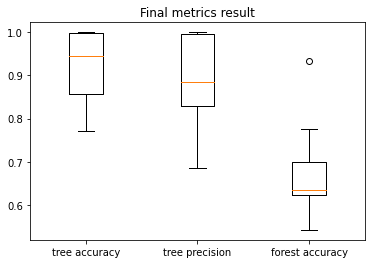

In [47]:
final_metrics = [[], [], []]
for client in clients:
    final_metrics[0].append(client.local_tree_acc)
    final_metrics[1].append(client.local_tree_prec)
    final_metrics[2].append(client.local_forest_acc)

plt.boxplot(final_metrics)
plt.title('Final metrics result')
plt.xticks([1, 2, 3], ['tree accuracy', 'tree precision', 'forest accuracy'])
plt.show()